<a href="https://colab.research.google.com/github/ImeldaMasika/Data_Science_Portfolio_Projects/blob/main/04_vector_autoregressive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use the VAR model for macro fundamentals forecasts

**The Vector Autoregressive (VAR) model is an extension of the Autoregressive (AR) model used for analyzing and forecasting multiple time series simultaneously. While the AR(p) model deals with a single time series, the VAR(p) model extends this concept to multiple related time series, creating a system of equations.**

**The VAR(p) model is a powerful tool for modeling and forecasting multiple related time series together. It considers both the own dynamics of each series and the cross-variable interactions, providing a comprehensive view of how these variables evolve over time and influence each other. This makes it valuable for various applications, including economic and financial modeling, macroeconomic forecasting, and understanding complex systems with multiple interrelated components.**

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [3]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

## Helper Functions

### Correlogram Plot

In [4]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Load Data

In [5]:
# Define the currency pair and date range
currency_pair = 'EURUSD=X'  # Example: Euro to US Dollar
start_date = '2020-01-01'
end_date = '2023-09-01'

# Create a Ticker object for the currency pair
forex_data = yf.Ticker(currency_pair)

# Fetch historical data for the specified date range
forex_history = forex_data.history(start=start_date, end=end_date)

In [6]:
# Remove the time component from the index directly
#forex_history.index = pd.to_datetime(forex_history.index).date

#forex_history.head()

In [7]:
forex_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 957 entries, 2020-01-01 00:00:00+00:00 to 2023-08-31 00:00:00+01:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          957 non-null    float64
 1   High          957 non-null    float64
 2   Low           957 non-null    float64
 3   Close         957 non-null    float64
 4   Volume        957 non-null    int64  
 5   Dividends     957 non-null    float64
 6   Stock Splits  957 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 59.8 KB


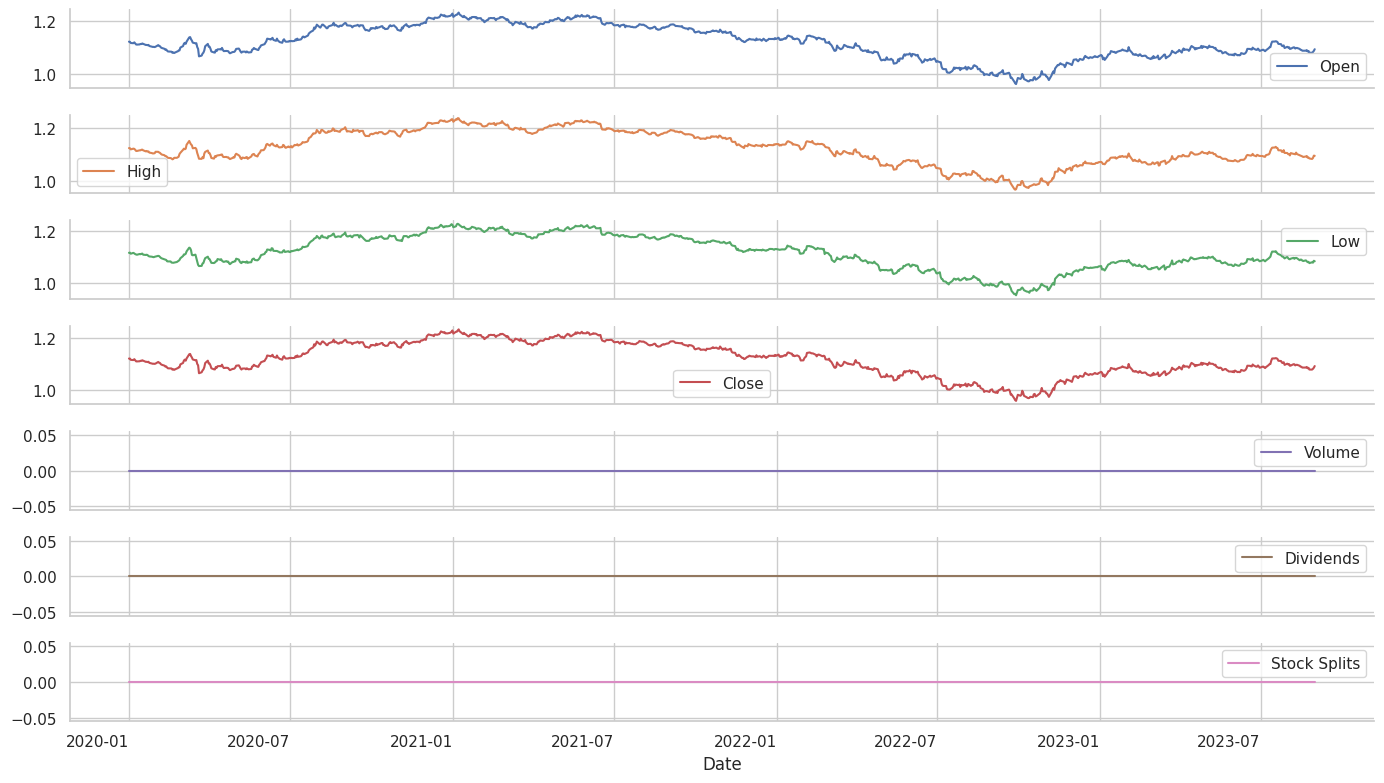

In [8]:
forex_history.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine() ## It removes the top and right spines (the lines on the top and right sides of the plot) to improve the aesthetics of the plot.
plt.tight_layout();

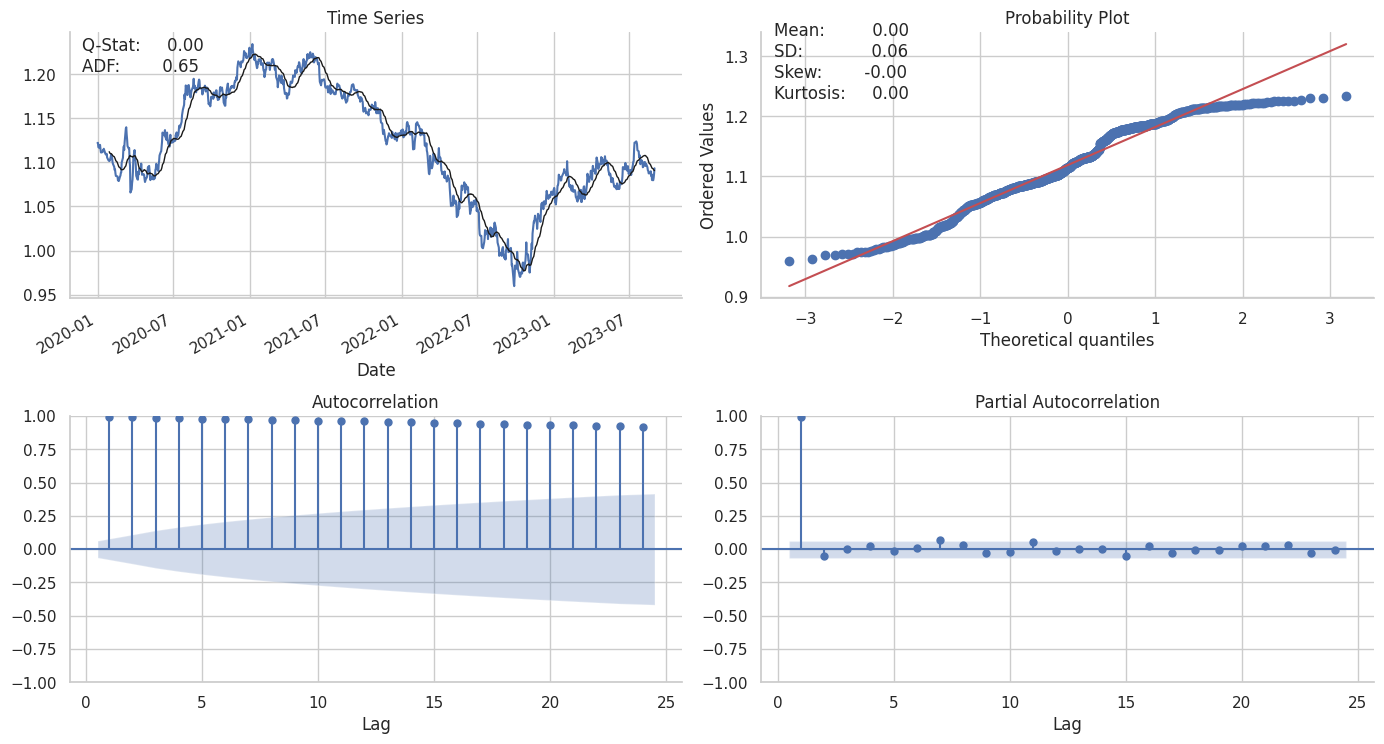

In [9]:
plot_correlogram(forex_history.Close, lags=24)

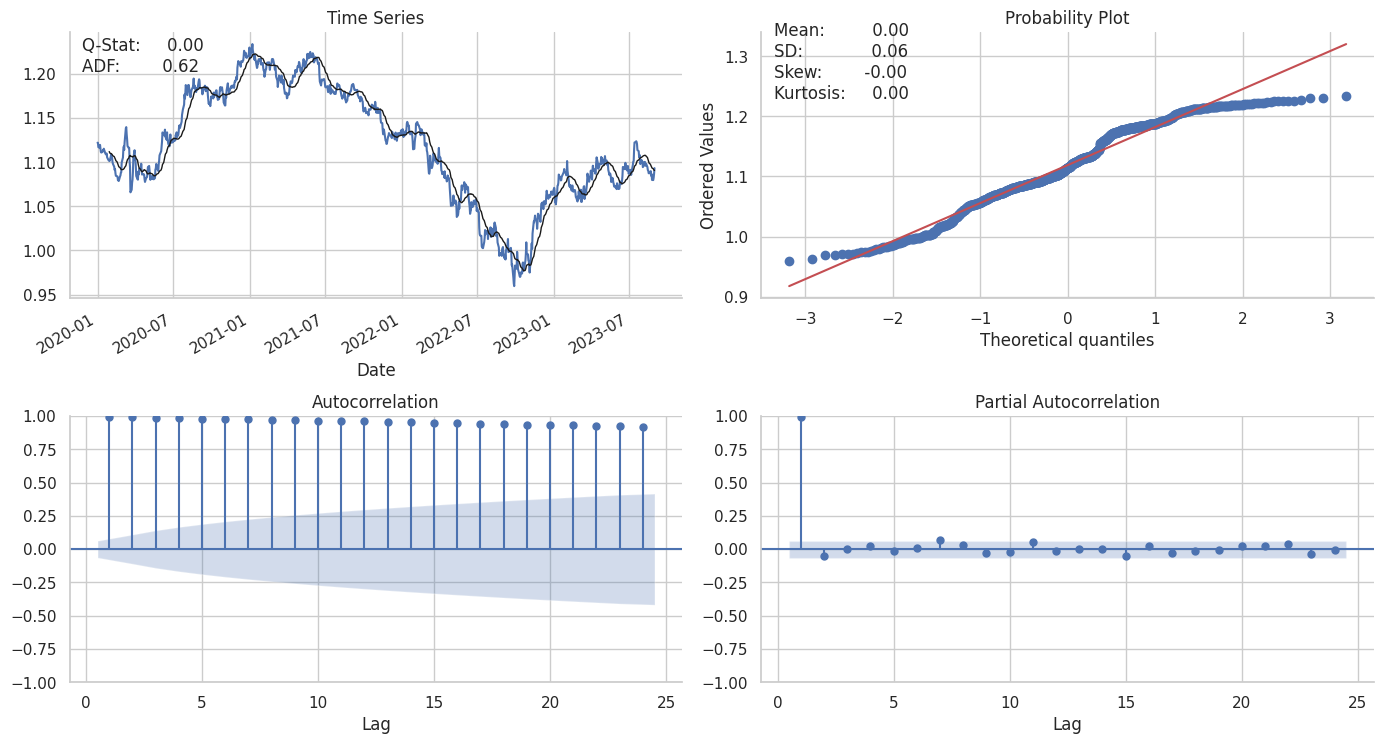

In [10]:
plot_correlogram(forex_history.Open, lags=24)

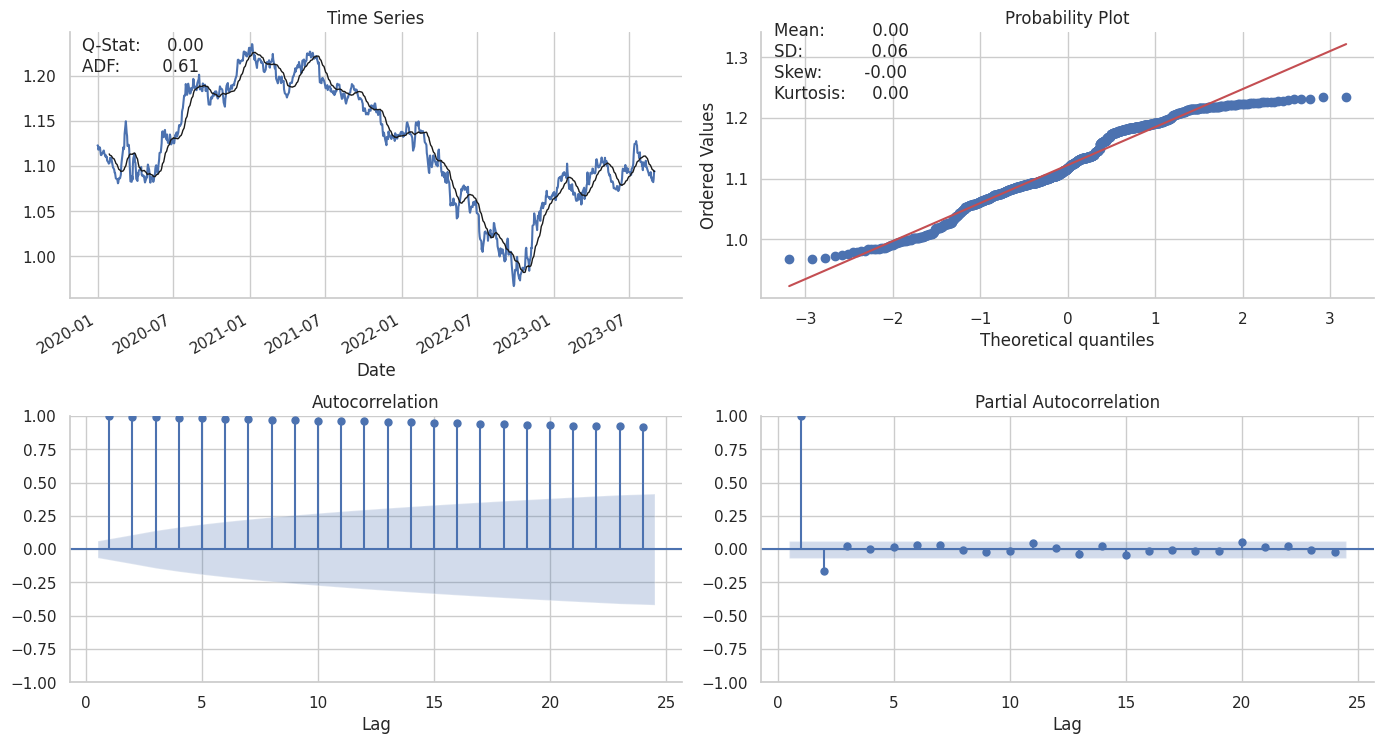

In [65]:
plot_correlogram(forex_history.High, lags=24)

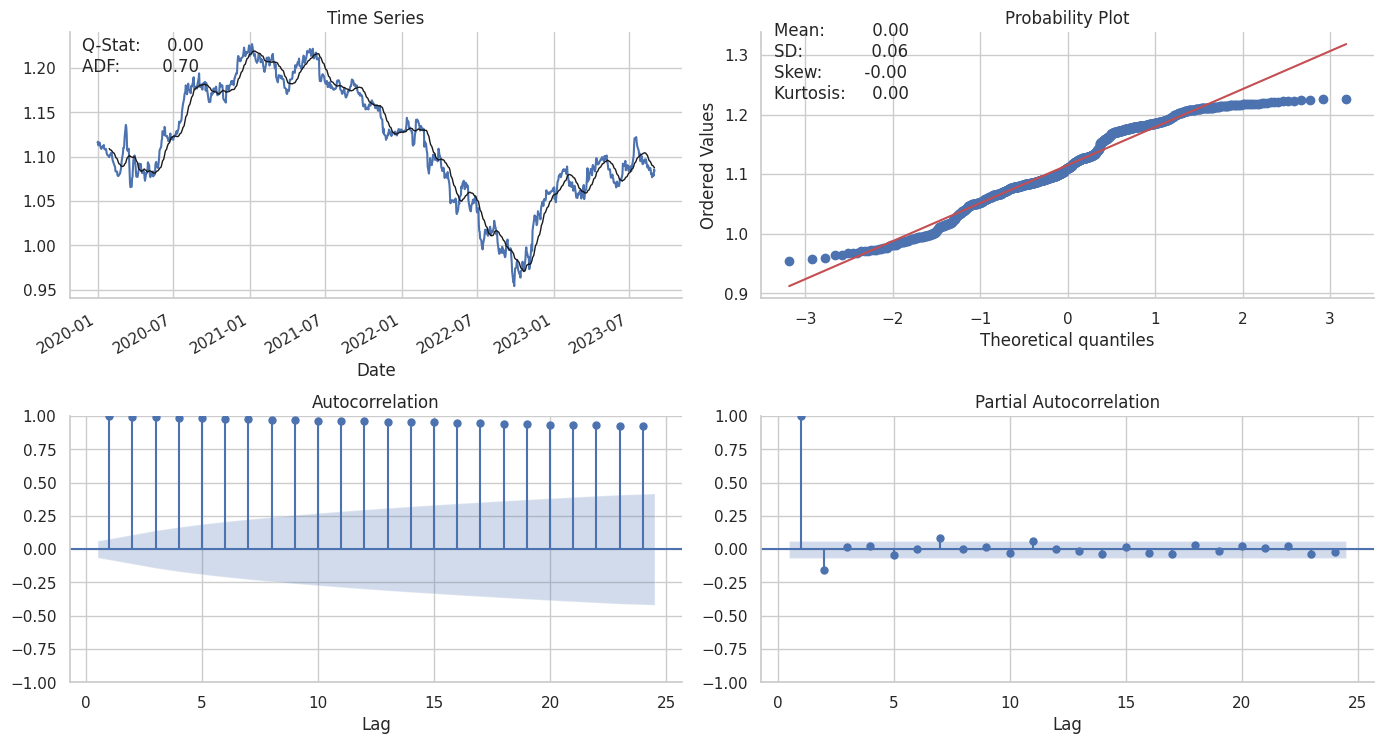

In [66]:
plot_correlogram(forex_history.Low, lags=24)

## Stationarity Transform

Log-transforming the industrial production series and seasonal differencing using lag 12 of both series yields stationary results:

In [11]:
#'Open': np.log(forex_history.Open).diff(12)

In [32]:
df_transformed = pd.DataFrame({'Open': forex_history.Open.diff(12),
                              'Close': forex_history.Close.diff(12),
                              'Low' : forex_history.Low.diff(12),
                              'High': forex_history.High.diff(12)}).dropna()

In [33]:
df_transformed

,Open,Close,Low,High
Date,,,,
2020-01-17 00:00:00+00:00,-0.008282,-0.008125,-0.007189,-0.008338
2020-01-20 00:00:00+00:00,-0.012373,-0.012623,-0.008931,-0.012218
2020-01-21 00:00:00+00:00,-0.007437,-0.007451,-0.003922,-0.006092
2020-01-22 00:00:00+00:00,-0.007660,-0.007635,-0.008648,-0.011046
2020-01-23 00:00:00+00:00,-0.009828,-0.010156,-0.009783,-0.009625
...,...,...,...,...
2023-08-25 00:00:00+01:00,-0.015977,-0.015977,-0.018921,-0.015457
2023-08-28 00:00:00+01:00,-0.018028,-0.018028,-0.016867,-0.023706
2023-08-29 00:00:00+01:00,-0.015609,-0.015609,-0.016829,-0.014767


## Inspect Correlograms

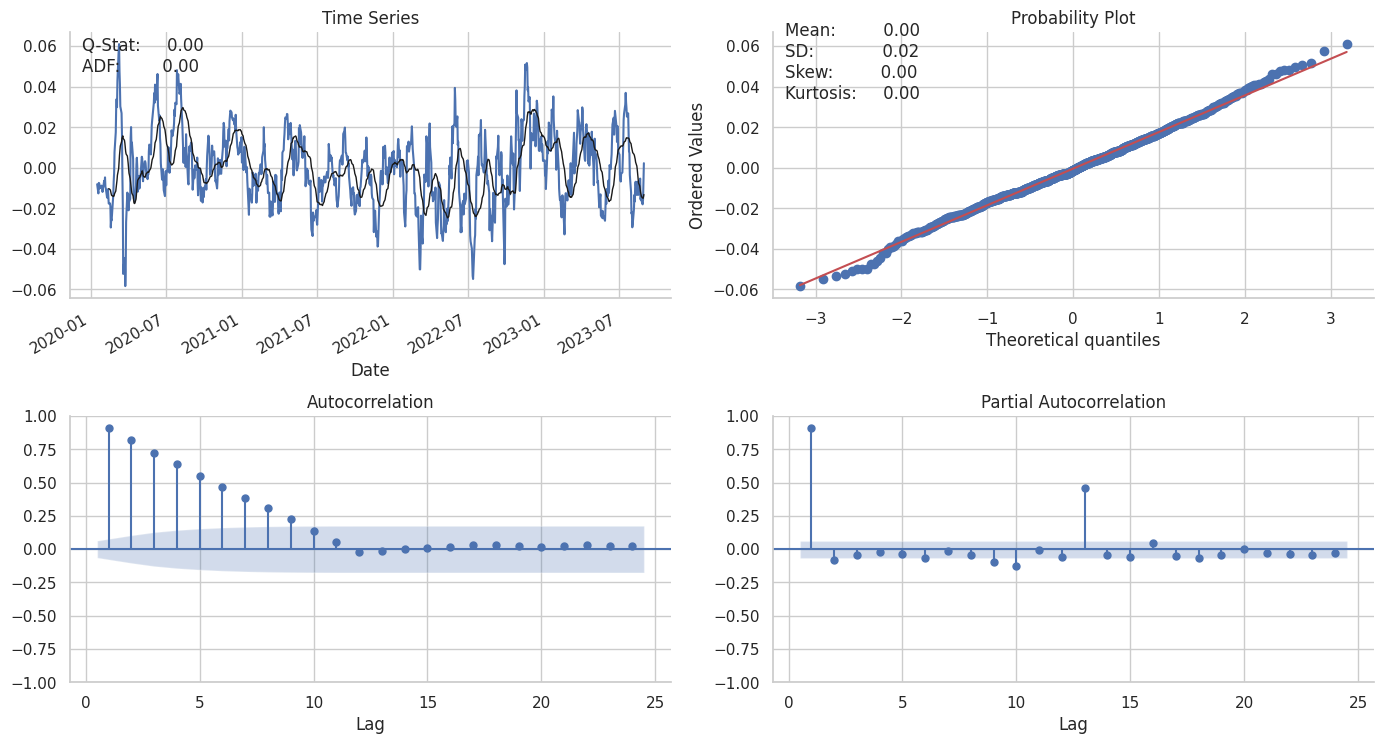

In [34]:
plot_correlogram(df_transformed.Close, lags=24)

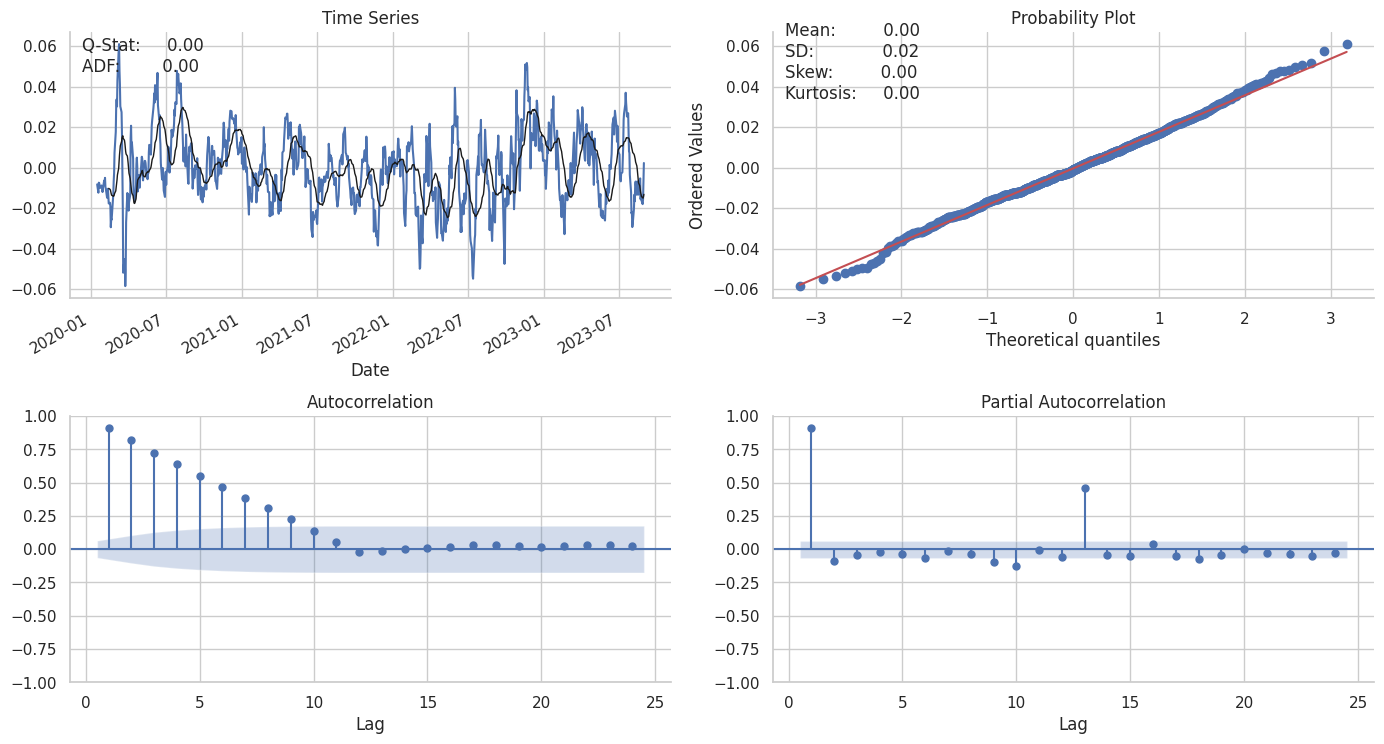

In [35]:
plot_correlogram(df_transformed.Open, lags=24)

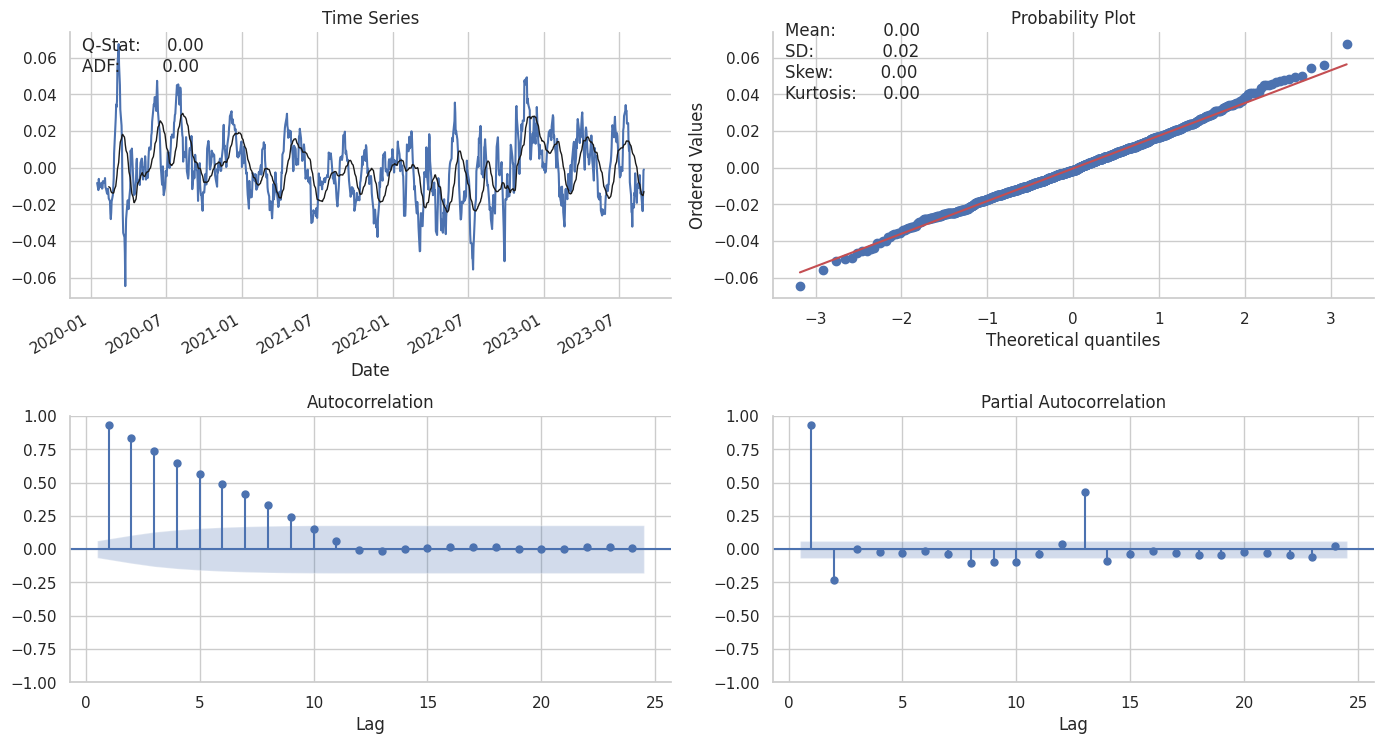

In [36]:
plot_correlogram(df_transformed.High, lags=24)

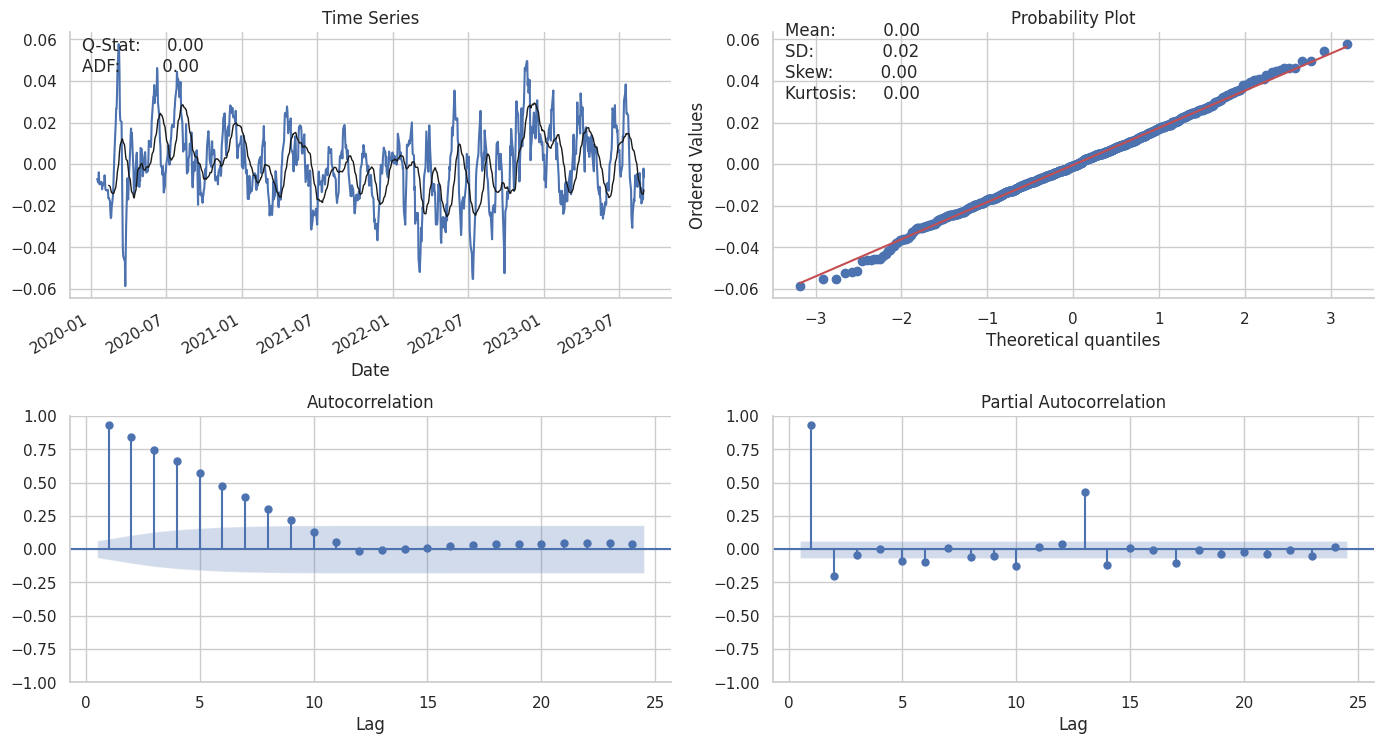

In [37]:
plot_correlogram(df_transformed.Low, lags=24)

In [38]:
### Unit Root Test
def test_unit_root(df_transformed):
    return df_transformed.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

In [39]:
test_unit_root(df_transformed)

,p-value
Open,0.00%
Close,0.00%
Low,0.00%
High,0.00%


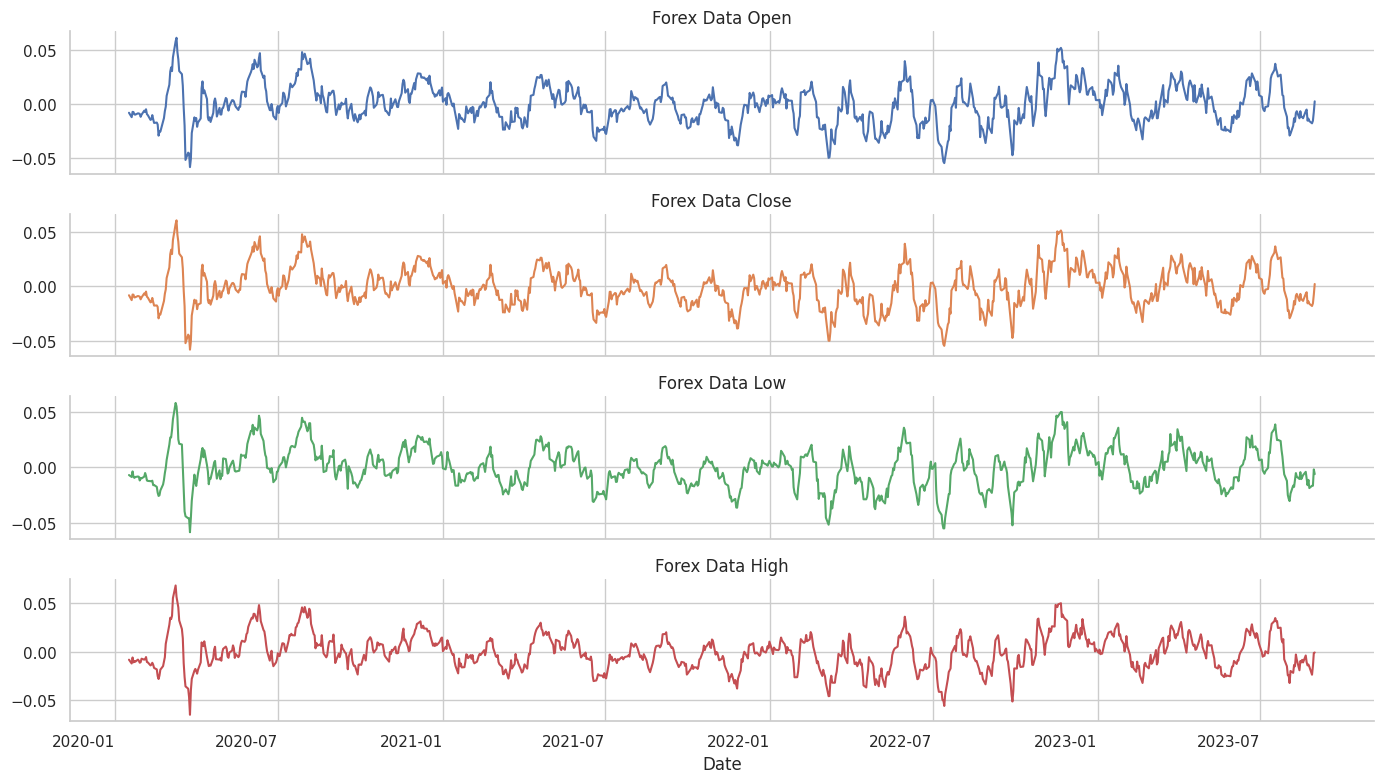

In [40]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Forex Data Open', 'Forex Data Close', 'Forex Data Low', 'Forex Data High'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()

## VAR Model

To limit the size of the output, we will just estimate a VAR(1) model using the statsmodels VARMAX implementation (which allows for optional exogenous variables) with a constant trend through 2017. The output contains the coefficients for both time series equations.

In [41]:
df_transformed = df_transformed.apply(minmax_scale)

In [42]:
df_transformed

,Open,Close,Low,High
Date,,,,
2020-01-17 00:00:00+00:00,0.420289,0.420781,0.442272,0.426095
2020-01-20 00:00:00+00:00,0.386047,0.383083,0.427301,0.396725
2020-01-21 00:00:00+00:00,0.427362,0.426430,0.470338,0.443097
2020-01-22 00:00:00+00:00,0.425499,0.424887,0.429737,0.405602
2020-01-23 00:00:00+00:00,0.407353,0.403763,0.419985,0.416357
...,...,...,...,...
2023-08-25 00:00:00+01:00,0.355880,0.354982,0.341470,0.372211
2023-08-28 00:00:00+01:00,0.338706,0.337789,0.359115,0.309774
2023-08-29 00:00:00+01:00,0.358957,0.358062,0.359439,0.377437


In [45]:
model = VARMAX(df_transformed.loc[:'2022'], order=(2,2), trend='c').fit(maxiter=1000)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
print(model.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'Close', 'Low', 'High']   No. Observations:                  771
Model:                                   VARMA(2,2)   Log Likelihood                8374.938
                                        + intercept   AIC                         -16593.877
Date:                              Sat, 16 Sep 2023   BIC                         -16231.357
Time:                                      20:38:35   HQIC                        -16454.371
Sample:                                           0                                         
                                              - 771                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):     0.00, 0.00, 0.00, 0.00   Jarque-Bera (JB):   67.57, 3178.22, 102.73, 163.90
Prob(Q):                0.97, 0.98, 0.98, 0.95   Prob(JB):     

### Plot Diagnostics

`statsmodels` provides diagnostic plots to check whether the residuals meet the white noise assumptions, which are not exactly met in this simple case:

#### Model Diagonistics

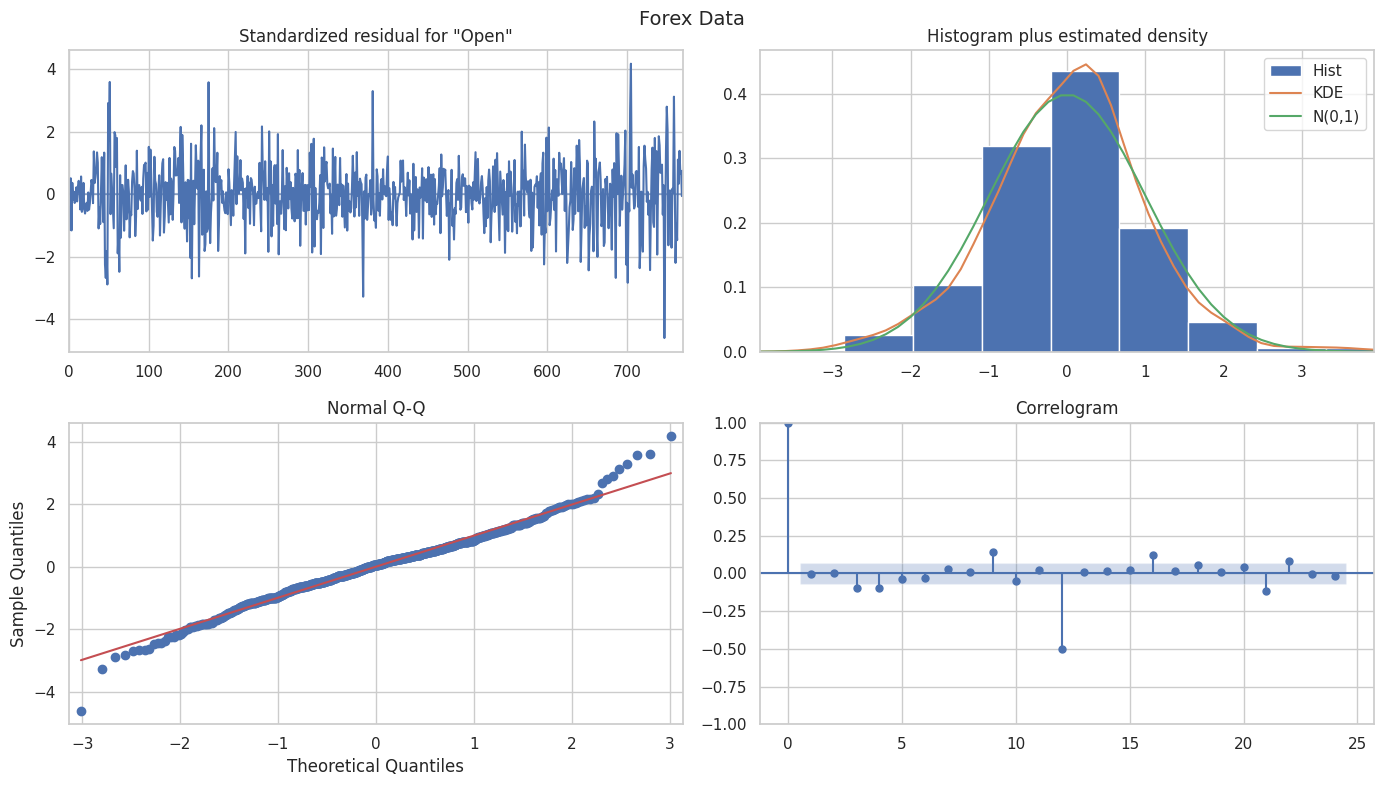

In [47]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Forex Data', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

#### Close

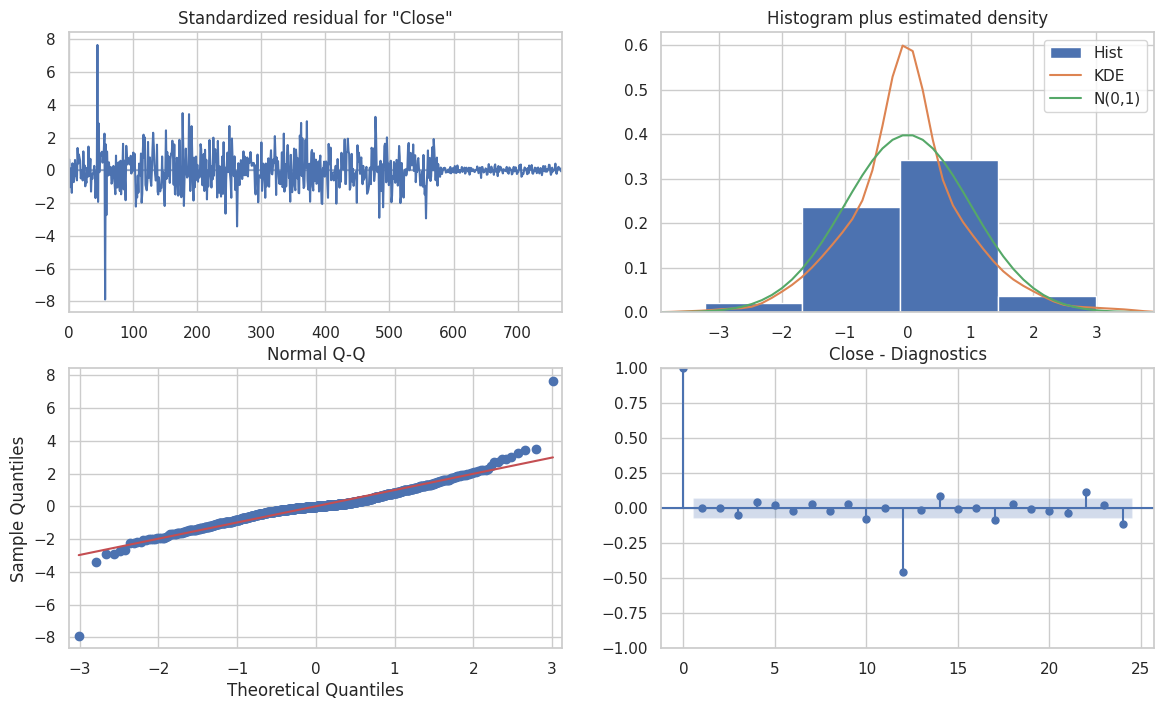

In [48]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Close - Diagnostics');

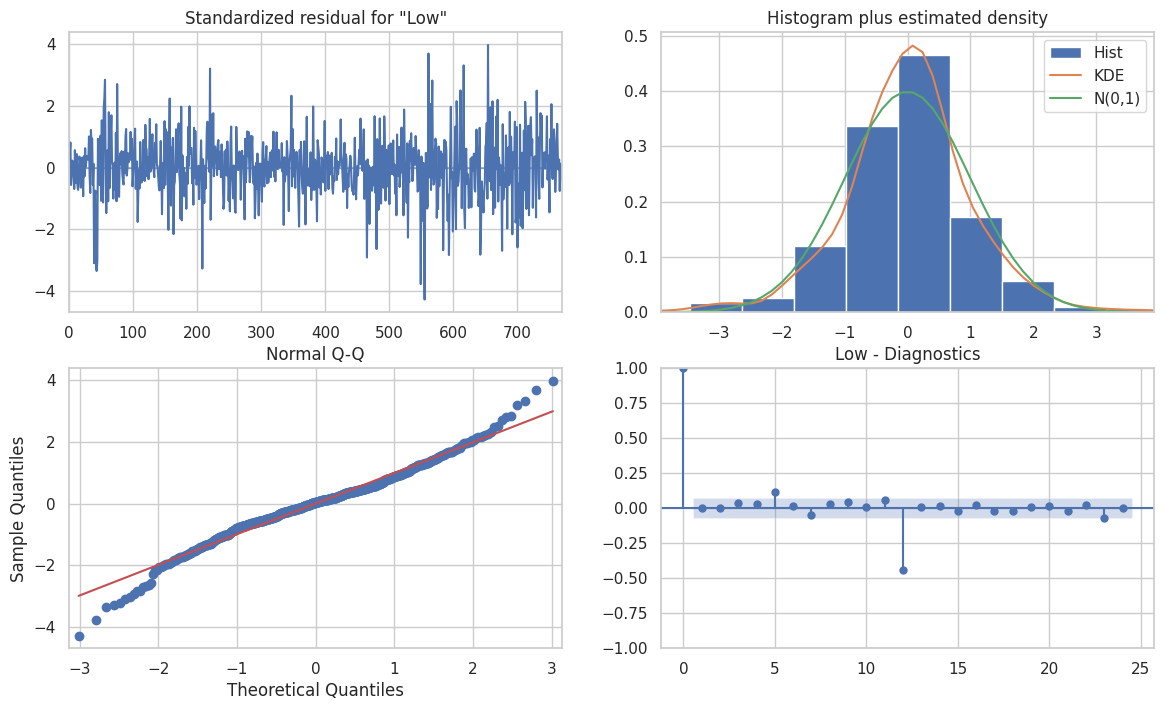

In [52]:
model.plot_diagnostics(variable=2, figsize=(14,8), lags=24)
plt.title('Low - Diagnostics');

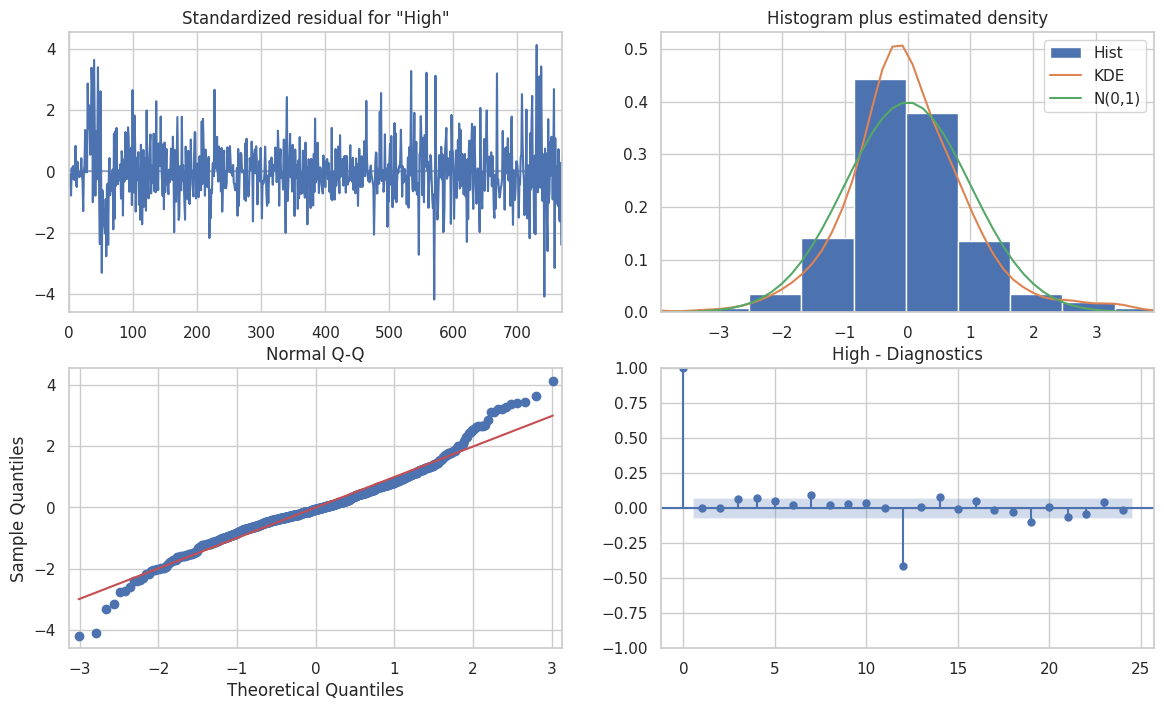

In [53]:
model.plot_diagnostics(variable=3, figsize=(14,8), lags=24)
plt.title('High - Diagnostics');

### Impulse-Response Function

**This code calculates and visualizes the impulse responses of a VARMA model to median-sized shocks in each variable for the next 12 time steps. The resulting plots show how each variable responds to these shocks over time, providing insights into the dynamic interactions between the variables in the model.**







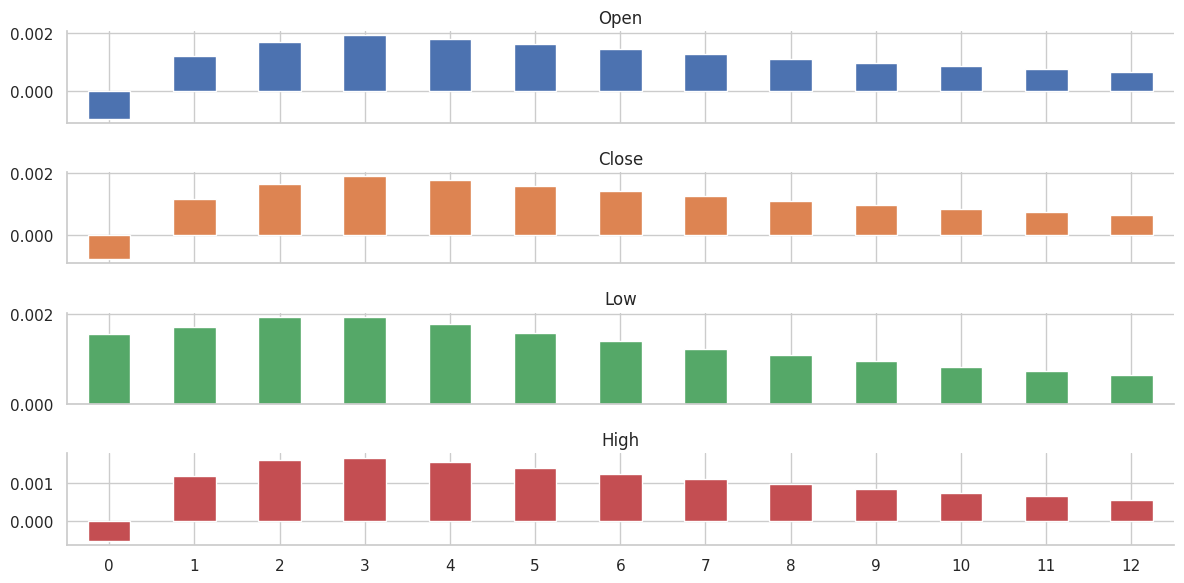

In [54]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,                                       #Impulse responses measure how each variable responds to a shock (impulse) in
                        impulse=median_change).plot.bar(subplots=True,  # one of the variables while holding other variables constant.
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

### Generate Predictions

Out-of-sample predictions can be generated as follows:

In [55]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)  #makes predictions using the VARMA model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


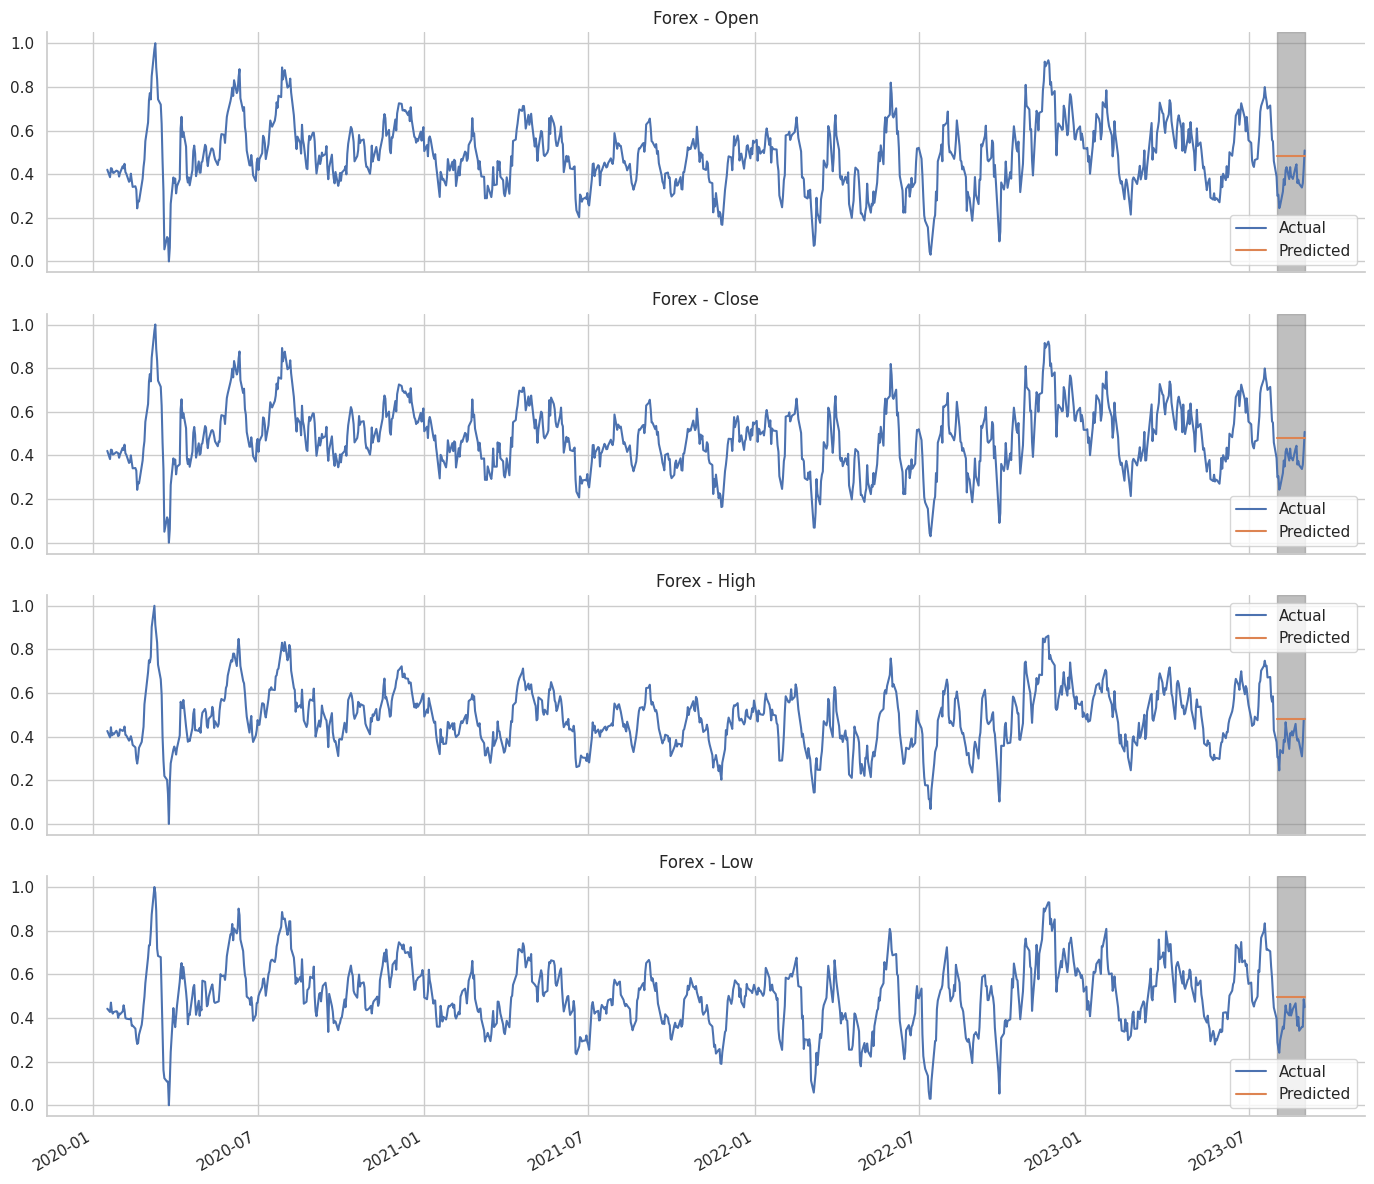

In [57]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=4, figsize=(14, 12), sharex=True)

# Plot 'Open'
df_transformed.Open.loc['2020':].plot(ax=axes[0], label='Actual', title='Forex - Open')
preds.Open.plot(label='Predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

# Plot 'Close'
df_transformed.Close.loc['2020':].plot(ax=axes[1], label='Actual', title='Forex - Close')
preds.Close.plot(label='Predicted', ax=axes[1])
trans = mtransforms.blended_transform_factory(axes[1].transData, axes[1].transAxes)
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

# Plot 'High'
df_transformed.High.loc['2020':].plot(ax=axes[2], label='Actual', title='Forex - High')
preds.High.plot(label='Predicted', ax=axes[2])
trans = mtransforms.blended_transform_factory(axes[2].transData, axes[2].transAxes)
axes[2].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

# Plot 'Low'
df_transformed.Low.loc['2020':].plot(ax=axes[3], label='Actual', title='Forex - Low')
preds.Low.plot(label='Predicted', ax=axes[3])
trans = mtransforms.blended_transform_factory(axes[3].transData, axes[3].transAxes)
axes[3].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

for ax in axes:
    ax.legend()
    ax.set_xlabel('')
    sns.despine()

fig.tight_layout()


### Out-of-sample forecasts

A visualization of actual and predicted values shows how the prediction lags the actual values and does not capture non-linear out-of-sample patterns well:

In [58]:
forecast = model.forecast(steps=24)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


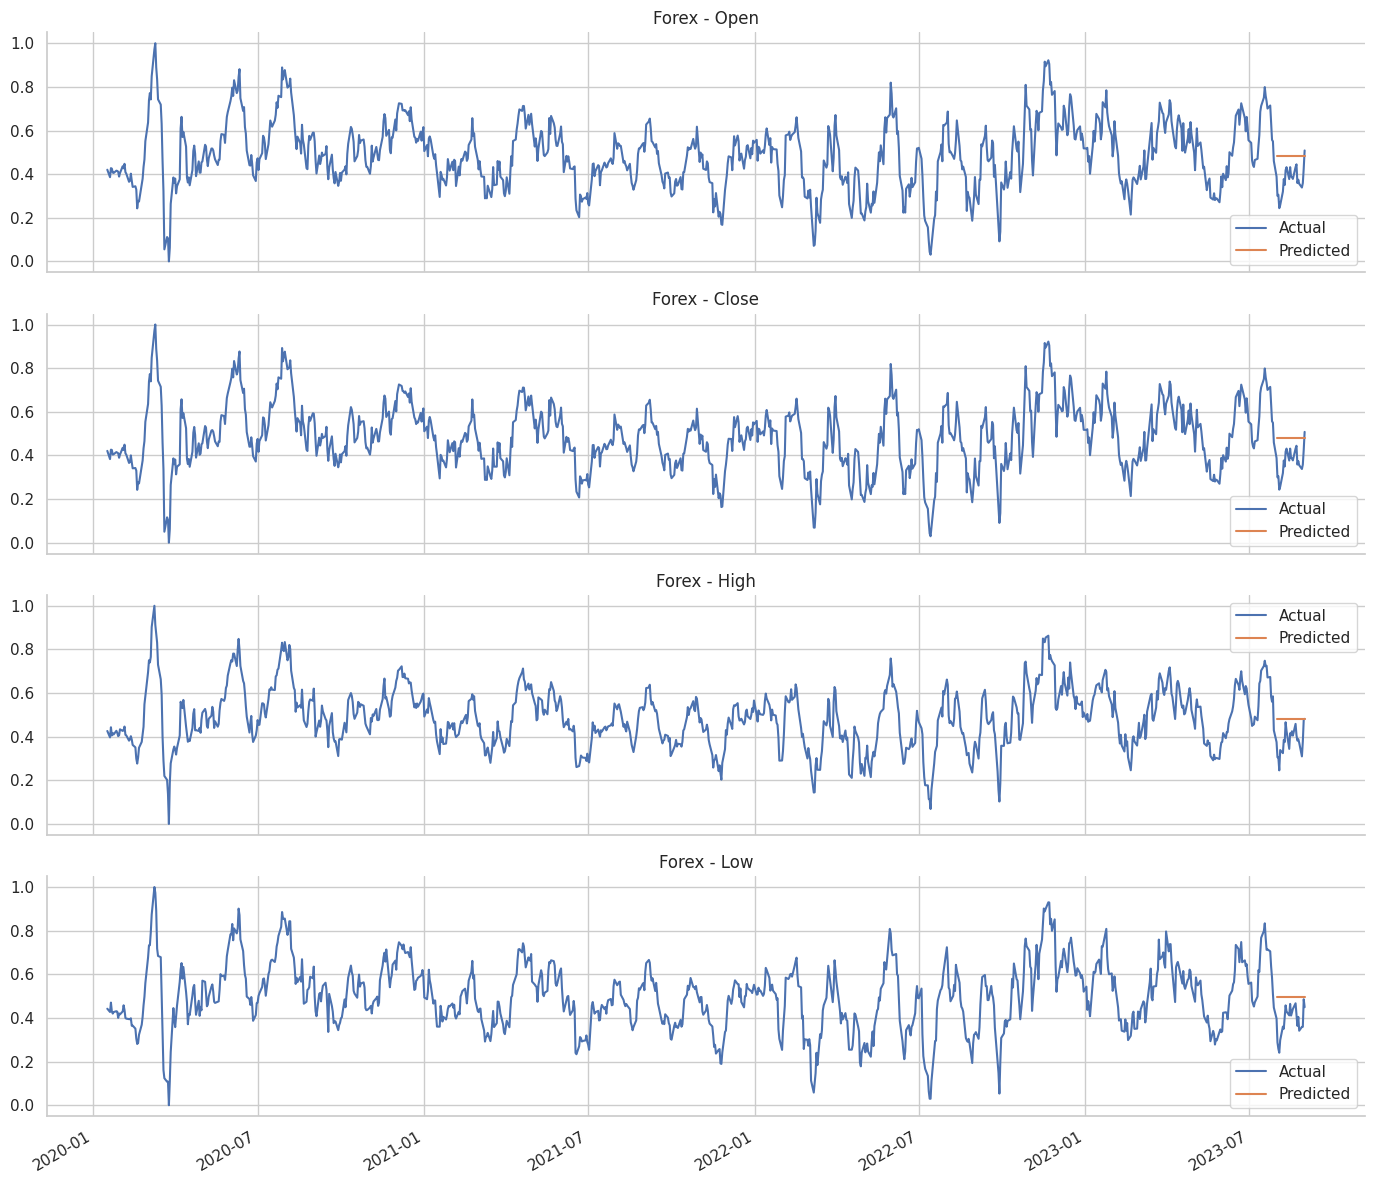

In [59]:
fig, axes = plt.subplots(nrows=4, figsize=(14, 12), sharex=True)

# Plot 'Open'
df_transformed['2020':].Open.plot(ax=axes[0], label='Actual', title='Forex - Open')
preds.Open.plot(label='Predicted', ax=axes[0])
axes[0].legend()

# Plot 'Close'
df_transformed['2020':].Close.plot(ax=axes[1], label='Actual', title='Forex - Close')
preds.Close.plot(label='Predicted', ax=axes[1])
axes[1].legend()

# Plot 'High'
df_transformed['2020':].High.plot(ax=axes[2], label='Actual', title='Forex - High')
preds.High.plot(label='Predicted', ax=axes[2])
axes[2].legend()

# Plot 'Low'
df_transformed['2020':].Low.plot(ax=axes[3], label='Actual', title='Forex - Low')
preds.Low.plot(label='Predicted', ax=axes[3])
axes[3].legend()

axes[3].set_xlabel('')
sns.despine()
fig.tight_layout()


In [63]:
mean_absolute_error(forecast, df_transformed.iloc[24:])

ValueError: ignored